# Tutorial: fitting a BL Lac broad-band SED using MCMC fit with Gammapy

In this tutorial, we will perform again the fit of the MWL SED of Mrk421 [illustrated in the previous notebook](ssc_gammapy_fit.ipynb). This time, instead of the simple $\chi^2$ minimisation with `iminuit`, we will perform a fit with a Monte Carlo Markov Chain (MCMC) method. As for the case of the simple $\chi^2$ minimisation, we will rely on `Gammapy`'s functionalities for data handling and fitting.

Some `Gammapy` functions wrapping the MCMC package, [`emcee`](https://emcee.readthedocs.io/en/stable/), are available in the [`gammapy-recipes`](https://gammapy.github.io/gammapy-recipes/_build/html/index.html). Please download the [`gammapy-recipes` repository](https://github.com/gammapy/gammapy-recipes) to run the code in this notebook.

An excellent theoretical introduction to MCMC methods can be found in [these notes](https://arxiv.org/abs/1909.12313).

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import c
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.wrappers import SynchrotronSelfComptonSpectralModel
from agnpy.wrappers import add_systematic_errors_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import SPECTRAL_MODEL_REGISTRY, SkyModel
from gammapy.estimators import FluxPoints
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(SynchrotronSelfComptonSpectralModel)

In [2]:
# the run_mcmc method has been moved from gammapy/gammapy to gammapy/recipes
# please download the gammapy-recipes
# https://github.com/gammapy/gammapy-recipes
# and change the following path accordingly
import sys

sys.path.append("/Users/cosimo/work/gammapy-recipes/recipes/mcmc-sampling-emcee")
from sampling import (
    run_mcmc,
    par_to_model,
    plot_corner,
    plot_trace,
)

### `gammapy` wrapper of agnpy synchrotron and SSC
Please refer to the [previous notebook](ssc_gammapy_fit.ipynb) for a description of the `Gammapy` wrapper of the synchrotron and SSC radiative processes.

In [3]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e=1.3e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the Gammapy SpectralModel
ssc_model = SynchrotronSelfComptonSpectralModel(n_e)

In [4]:
# reasonable intial parameters
ssc_model.parameters["z"].value = 0.0308
ssc_model.parameters["delta_D"].value = 18
ssc_model.parameters["t_var"].value = (1 * u.d).to_value("s")
ssc_model.parameters["t_var"].frozen = True
ssc_model.parameters["log10_B"].value = -1.3

In [5]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k_e,-7.8861e+00,,0.000e+00,-1.000e+01,2.000e+00,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,1.000e+00,3.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,5.000e+00,8.000e+00,True,False,
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-1.3000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,


### Fit with `gammapy`
Here we start the procedure to fit with `Gammapy`.

#### 1) load the MWL flux points and add the systematics 
As in the previous example, we define a `FluxPointsDataset` for each instrument. We then proceed to add systematic errors using a very rough and conservative estimate ($30\%$ of the flux for VHE points, $10\%$ for HE and X-ray points, $5\%$ on all the other instruments data).

In [6]:
datasets = Datasets()
flux_points = {}

sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
table = Table.read(sed_path)
table = table.group_by("instrument")

# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())

for group in table.groups:
    name = group["instrument"][0]

    data = FluxPoints.from_table(group, sed_type="e2dnde", format="gadf-sed")
    dataset = FluxPointsDataset(data=data, name=name)

    flux_points.update({name: data})
    dataset.mask_fit = dataset.data.energy_ref > E_min_fit
    datasets.append(dataset)

# load the SSC model in the datasets
model = SkyModel(spectral_model=ssc_model, name="Mrk421")
datasets.models = [model]

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

In [7]:
# add systematic errors
for key in flux_points.keys():
    if key == "MAGIC":
        add_systematic_errors_flux_points(flux_points[key], 0.30)
    elif key in ["Fermi", "RXTE/PCA", "Swift/BAT", "Swift/XRT"]:
        add_systematic_errors_flux_points(flux_points[key], 0.10)
    else:
        add_systematic_errors_flux_points(flux_points[key], 0.05)

### 2) run the fit
We define here the parameters for the MCMC fit and run it with the `run_mcmc` function in the `Gammapy` recipes. `nwalkers` indicate the number of chains we want to use, a good rule is $n_{\rm walkers} \geq 2 \times n_{\rm free\;parameters}$. In this case we choose a number of walkers three times the number of free parameters (6, in this case). `nrun` indicates the number of steps of MCMC we want to perform. With the current settings, it will take roughly 1 hour, you can decrease one of the twi parameters for testing purposes.

In [8]:
%%time
sampler = run_mcmc(datasets, nwalkers=18, nrun=400)

CPU times: user 1h 19min 53s, sys: 10min 16s, total: 1h 30min 9s
Wall time: 1h 32min 49s


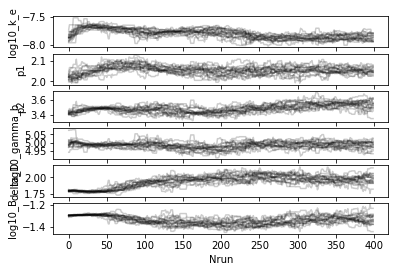

In [9]:
plot_trace(sampler, datasets)

The figure above shows the trace, i.e. the position of each walker as a function of the number of steps in the chain. One can estimate the *burn-in* period, i.e. the time needed for the walkers to reach a stationary stage). To make this estimate more precise, take a look at [emcee's autocorrelation and analysis and convergence](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr). For the sake of this example, and since it takes already a while to run this notebook, we will assume that after 300 steps the walkers are already burnt in.

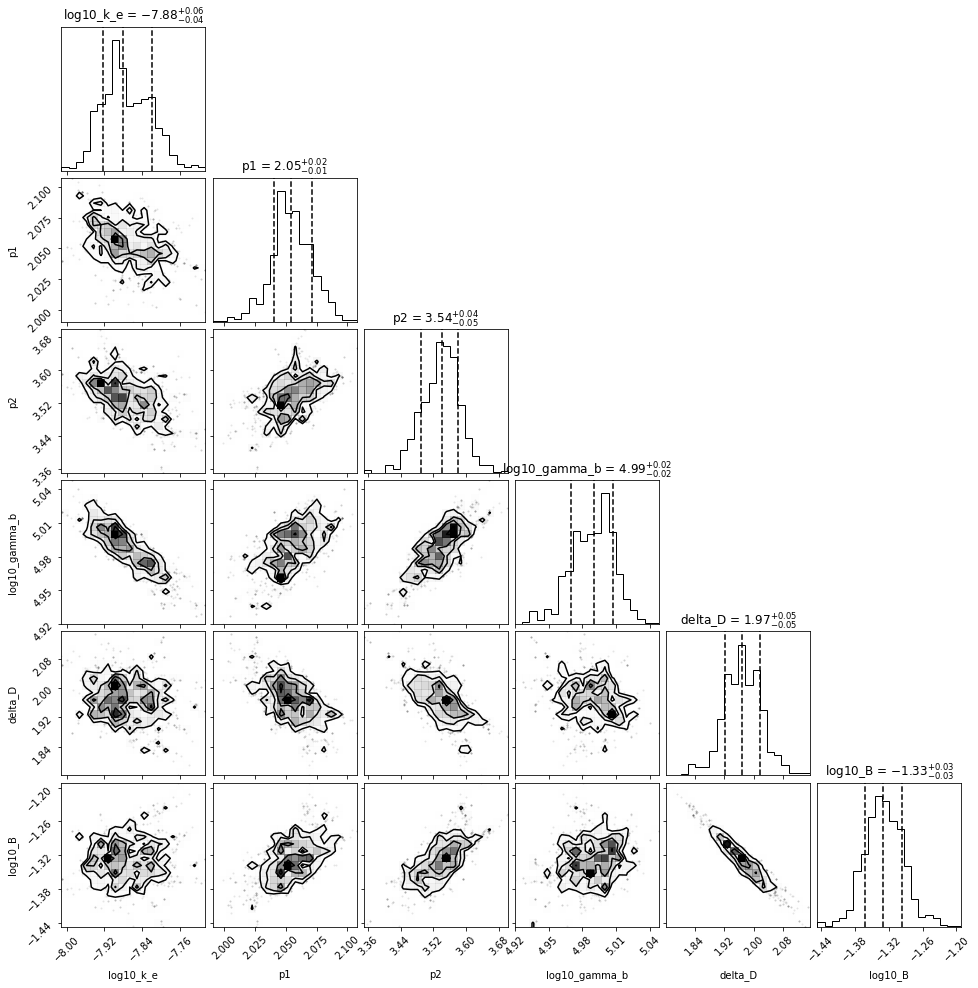

In [10]:
plot_corner(sampler, datasets, nburn=300)

The figure above represents a *corner plot*. It shows different marginalisations of the total posterior distribution. Note that in this case, by default, a flat prior was used, spanning the interval we set through the `min` and `max` of each parameter. 

The diagonal panels with the single histograms show the 1-D marginalised posterior distribution for each parameter, along with the corresponding median and 68% credible interval. They represent an estimate of the parameters and their errors. Each panel containing a 2-D histograms shows the the 2-D marginalized posterior distribution, along with the 16, 50 and 84% containment fraction. They illustrate the correlation between the different parameters.

#### 3) plot the results
To assess the results of our fit we can choose a small sample of parameters from the chain, and plot the corresponding models. We chose to plot the models corresponding to the last ten realisation of each walker.

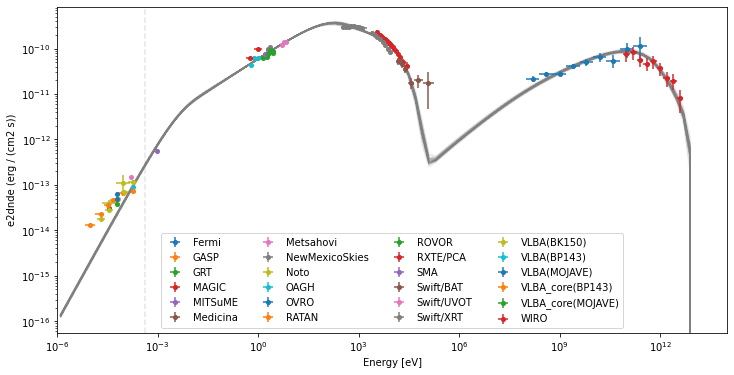

In [15]:
emin, emax = [1e-6, 1e14] * u.eV

fig, ax = plt.subplots(figsize=(12, 6))

for nwalk in range(0, 18):
    for n in range(390, 400):
        pars = sampler.chain[nwalk, n, :]

        # set model parameters
        par_to_model(datasets, pars)
        ssc_model = datasets.models["Mrk421"].spectral_model

        ssc_model.plot(
            energy_bounds=(emin, emax),
            ax=ax,
            energy_power=2,
            alpha=0.02,
            color="grey",
            yunits=u.Unit("erg cm-2 s-1"),
        )

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray", alpha=0.2)

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()

Which values should we use for the final parameters and their uncertainty? The [`emcee` documentation](https://emcee.readthedocs.io/en/stable/tutorials/line/#results) suggests to quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions.

In [49]:
from IPython.display import display, Math

for i, par in enumerate(
    [
        "\log_{10}(k_{\mathrm e}\,/\,{\mathrm cm}^{-3})",
        "p_1",
        "p_2",
        "\log_{10}(\gamma_{\mathrm b})",
        "\delta_{\mathrm D}",
        "\log_{10}(B\,/\,{\mathrm G})",
    ]
):

    # the sampler.chain has shape (# walker, # steps, # parameters)
    par_values = sampler.chain[:, 300:, i].flatten()
    mcmc = np.quantile(par_values, [0.16, 0.50, 0.84])
    q = np.diff(mcmc)

    txt = "{3} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], par)
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can observe a very nice agreement with the parameters values and errors obtained with the simple $\chi^2$ minimisation in the previous tutorial.